In [1]:
import os, sys
sys.path.append("/home/alexanderalbizu")
sys.path.append("/home/alexanderalbizu/.local/bin")
os.environ["WANDB_NOTEBOOK_NAME"] = "CNN_II.ipynb"
#!python setup.py develop 
#!pip install wandb
#!pip install 'monai[all]'
#!pip -q install vit_pytorch
#!pip -q install linformer
#!pip3 install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install git+https://github.com/shijianjian/EfficientNet-PyTorch-3D

In [2]:
import glob, math, os, time, monai, torch, random

import numpy as np
import wandb as wb
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib

from enum import Enum
from torch import nn
from torch.utils import data as torch_data
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from monai.networks import nets
from monai.networks.utils import eval_mode
from monai.data import (
    DataLoader,
    ImageReader,
    ImageDataset,
    ArrayDataset,
)
from monai.transforms import (
    AddChannel,
    AsChannelFirst,
    Compose,
    RandGaussianNoise,
    Resize,
    RemoveRepeatedChannel,
    Orientation,
    RandRotate90,
    RandBiasField,
    ScaleIntensity,
    ToDevice,
    EnsureType,
)
pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
wb.login(); # 7e5f63e5846f29b034d98806712ab047df76834d

wandb: Currently logged in as: aalbizu. Use `wandb login --relogin` to force relogin


In [3]:
# Settings
#######################################
rootDir = '/blue/camctrp/working/Alejandro/StimBrain/' # Set data directory
dims = np.array([182,218,182])
batch_size=16
im_size = (128,128)
pat_size = (16,16)
seed = 42
subs = np.array([9009, 9015, 9022, 9040, 9044, 9045, 9051, 9021, 9023, 9031, 9032, 9047, 9048, 9054]) # Subjects
beh = np.array([32, 26, 19, 20, 20, 17, 15, 2, 4, 6, 10, 16, 18, 7]) # Targeted Behavior Change
lr = 1e-4
wd = 0

# start a typical PyTorch training
val_interval = 1
epoch_loss_values = [] # Pre-Allocate
epoch_acc_values = [] # Pre-Allocate
max_epochs = 50
#######################################

num_cores = int(os.environ["SLURM_CPUS_PER_TASK"]);

# Define Group Labels as above/below Median
l = np.int64(np.zeros([len(beh),1]));
l[beh >= np.median(beh)] = 1; # Responders
l[beh < np.median(beh)] = 0; # Non Responders

class Diagnosis(Enum):
    NonResponder = 0
    Responder = 1

images = []; butt = 0; 
lab = []
for s in range(subs.shape[0]):
    for n in range(dims[2]):
        if n < 30 or n > 150: continue
        images.append(os.path.join(rootDir,'FS6.0_sub-'+str(subs[s])+'_ses01','sub-'+str(subs[s])+'_n'+str(n+1)+'_Jxyz.png'));
        lab.append(l[s]);
        butt += 1
images = np.asarray(images); lab = np.asarray(lab);
print(images.shape,lab.shape)
# Plot Labels
plt.rcParams['figure.figsize'] = [20, 20]; plt.imshow([lab]); plt.axis('off'); plt.title('Class Labels');

(1694,) (1694, 1)


train case split:  1372 : 1370
valid case split:  76 : 77
test case split:  85 : 85 

/blue/camctrp/working/Alejandro/StimBrain/FS6.0_sub-9023_ses01/sub-9023_n63_Jxyz.png
(182, 218, 3)


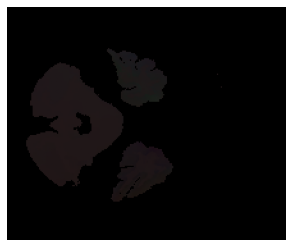

In [4]:
# def seed_everything(seed):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     torch.backends.cudnn.deterministic = True
    
# seed_everything(seed)    

nontest_list, test_list = train_test_split(images, 
                                          test_size=0.10,
                                          stratify=lab,
                                          random_state=seed)
nontest_label, test_label = train_test_split(lab, 
                                          test_size=0.10,
                                          stratify=lab,
                                          random_state=seed)
train_list, valid_list = train_test_split(nontest_list, 
                                          test_size=0.10,
                                          stratify=nontest_label,
                                          random_state=seed)
train_label, valid_label = train_test_split(nontest_label, 
                                          test_size=0.10,
                                          stratify=nontest_label,
                                          random_state=seed)
# Oversampling the Unbalnaced Class
train_list = np.array(np.hstack([[train_list.T],[train_list.T]]))[0,:];
train_label = np.array([np.int64(np.hstack([train_label[:,0],train_label[:,0]]))]).T;

print('train case split: ',sum(train_label)[0],':',len(train_label)-sum(train_label)[0])
print('valid case split: ',sum(valid_label)[0],':',len(valid_label)-sum(valid_label)[0])
print('test case split: ',sum(test_label)[0],':',len(test_label)-sum(test_label)[0],'\n')
del nontest_list, nontest_label; # Save RAM

# Plot Responder Mean
plt.rcParams['figure.figsize'] = [5,5];
print(images[1000])
img = plt.imread(images[1000]); print(img.shape) # Load Each Electrode
plt.imshow(img, cmap="jet", origin="lower", vmin=0, vmax=1e-100); plt.axis('off'); # Plot

torch.Size([1, 3, 128, 128]) tensor([[0, 1]]) torch.Size([1, 2])


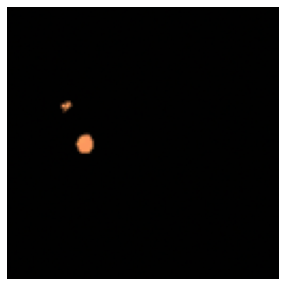

In [5]:
# Represent labels in one-hot format for binary classifier training,
# BCEWithLogitsLoss requires target to have same shape as input
labels = nn.functional.one_hot(torch.as_tensor(lab.T)).long();
train_lab = nn.functional.one_hot(torch.as_tensor(train_label.T)).long(); 
valid_lab = nn.functional.one_hot(torch.as_tensor(valid_label.T)).long();
test_lab = nn.functional.one_hot(torch.as_tensor(test_label.T)).long();

# Define transforms
train_transforms = Compose([
    AsChannelFirst(channel_dim=2),
#     AddChannel(),
    Resize(im_size),
#     RandBiasField(),
    RandGaussianNoise(prob=0.5), 
    ScaleIntensity(minv=0.0, maxv=1.0),
    EnsureType(data_type='tensor')]);

val_transforms = Compose([
    AsChannelFirst(channel_dim=2),
#     AddChannel(),
    Resize(im_size),
    ScaleIntensity(minv=0.0, maxv=1.0),
    EnsureType(data_type='tensor')]);

# Define nifti dataset, data loader
check_ds = ImageDataset(image_files=train_list, labels=train_lab[0,:,:], transform=train_transforms);
check_loader = DataLoader(check_ds, batch_size=1, num_workers=num_cores, pin_memory=pin_memory); 

im, label = monai.utils.misc.first(check_loader); print(im.shape, label, label.shape)
plt.imshow(im[0,:,:].T, cmap="turbo", origin="lower"); plt.axis('off'); del check_ds, check_loader, im, label;

# create a training data loader
train_ds = ImageDataset(image_files=train_list, labels=train_lab[0,:,:], transform=train_transforms);
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_cores, pin_memory=pin_memory);

# create a validation data loader
val_ds = ImageDataset(image_files=valid_list, labels=valid_lab[0,:,:], transform=val_transforms);
val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=num_cores, pin_memory=pin_memory)

# Train Model

In [ ]:
def save_model(n_epoch, save_path, run_id):
        lastmodel = f"{save_path}-{run_id}.pth"
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_valid_score": best_valid_score,
                "n_epoch": n_epoch,
            },
            lastmodel,
        )

# Create DenseNet121, CrossEntropyLoss and Adam optimizer
# model = VisionTransformer(in_chans=3,img_size=im_size[0],patch_size=pat_size[0],n_classes=2,n_heads=8).to(device)
model = monai.networks.nets.ViT(
    in_channels=3, 
    img_size=im_size, 
    patch_size=pat_size, 
    hidden_size=768, 
    mlp_dim=3072, 
    num_layers=12, 
    num_heads=12, 
    pos_embed='conv', 
    classification=True, 
    num_classes=2, 
    dropout_rate=0.1, 
    spatial_dims=2).to(device)

# Loss Function
loss_fx = nn.BCEWithLogitsLoss() 

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

wb.init(project="SMART-ViT",
           config={
               "batch_size": batch_size,
               "n_channels": 3,
               "n_epoch": max_epochs,
               "image_size": im_size,
               "learning_rate": lr,
               "network": "ViT",
               "weight_decay": wd,
               "dataset": "SB",
           })
run_id = wb.run.name;
wb.watch(model, log='all')

scaler = torch.cuda.amp.GradScaler()
best_valid_score = 99999; # Initialize Loss
lastmodel = None
for epoch in range(max_epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for batch_data in train_loader:
        inputs, label = batch_data[0].to(device), batch_data[1].to(device);
        
        # Update Gradient
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            # Evaluate Model
            output, hidden = model(inputs); epoch_prob = nn.functional.softmax(output,dim=1)
            loss = loss_fx(output, label.float())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update(); del hidden
        
        # Accuracy
        acc = (epoch_prob.argmax(dim=1) == label.argmax(dim=1)).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_acc_values.append(acc)
        
        # Loss
        epoch_loss += loss / len(train_loader)
        epoch_loss_values.append(epoch_loss)
#         print(f"train loss: {loss.item():.4f} - train acc: {acc:.4f}")
        wb.log({'train_loss': loss, 'train_acc': acc})

    if epoch % val_interval == 0: # Validation Interval
        with eval_mode(model):
            epoch_val_accuracy = 0; epoch_val_loss = 0;
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)

                val_output, hidden = model(val_images); val_prob = torch.nn.functional.softmax(val_output,dim=1); del hidden
                val_loss = loss_fx(val_output, val_labels.float())

                val_acc = (val_prob.argmax(dim=1) == val_labels.argmax(dim=1)).float().mean()
                epoch_val_accuracy += val_acc / len(val_loader)
                epoch_val_loss += val_loss / len(val_loader)
                wb.log({'val_loss': val_loss, 'val_acc': val_acc})
        print(
            f"Epoch : {epoch+1} - train_loss : {epoch_loss:.4f} - train_acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
        
        # Save Best Model
        if best_valid_score > epoch_val_loss:
            print("model saved")
            save_model(epoch, "T1", run_id)
            best_valid_score = epoch_val_loss
            
#     else:    
#         print(
#             f"Epoch : {epoch+1} - train_loss : {epoch_loss:.4f} - train_acc: {epoch_accuracy:.4f} \n"
#         )
        
wb.run.log_code(root=os.path.join(os.getcwd(),"CNN_SMART.ipynb")); wb.finish()

# Test Model

In [ ]:
modelfile = f'Jxyz-revived-leaf-5.pth'; # HARDCODED
checkpoint = torch.load(modelfile)

# create a validation data loader
test_ds = ImageDataset(image_files=test_list, labels=test_lab[0,:,:], transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers=num_cores, pin_memory=pin_memory)
model.load_state_dict(checkpoint["model_state_dict"])

with eval_mode(model):
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    test_acc = 0
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(
            device), test_data[1].to(device)

        outputs = model(test_images); probs = torch.nn.functional.softmax(outputs,dim=1);
        test_acc += (probs.argmax(dim=1) == test_labels.argmax(dim=1)).float().mean();
        y_pred = torch.cat([y_pred, probs.argmax(dim=1)], dim=0)
        y = torch.cat([y, test_labels.argmax(dim=1)], dim=0);
    test_acc = test_acc / len(test_loader)

print(classification_report(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    target_names=[d.name for d in Diagnosis]))

cm = confusion_matrix(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    normalize='true')

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[d.name for d in Diagnosis])

disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])

# Occulusion Sensitivity

In [ ]:
# cam = monai.visualize.CAM(nn_module=model_3d, target_layers="class_layers.relu", fc_layers="class_layers.out")
cam = monai.visualize.GradCAMpp(
    nn_module=model, target_layers="class_layers.relu"
)
# cam = monai.visualize.GradCAMpp(nn_module=model_3d, target_layers="class_layers.relu")
print(
    "original feature shape",
    cam.feature_map_size([1, 1] + list(im_size), device),
)
print("upsampled feature shape", [1, 1] + list(im_size))

occ_sens = monai.visualize.OcclusionSensitivity(
    nn_module=model, mask_size=12, n_batch=1, stride=24
)

# For occlusion sensitivity, inference must be run many times. Hence, we can use a
# bounding box to limit it to a 2D plane of interest (z=the_slice) where each of
# the arguments are the min and max for each of the dimensions (in this case CHWD).
the_slice = train_ds[0][0].shape[-1] // 2
occ_sens_b_box = [-1, -1, -1, -1, -1, -1, the_slice, the_slice]

train_transforms.set_random_state(42)
n_examples = 3
subplot_shape = [3, n_examples]
fig, axes = plt.subplots(*subplot_shape, figsize=(25, 15), facecolor="white")
items = np.random.choice(len(train_ds), size=len(train_ds), replace=False)

example = 0
for item in items:

    data = train_ds[
        item
    ]  # this fetches training data with random augmentations
    image, label = data[0].to(device).unsqueeze(0), data[1][1]
    y_pred = model(image); prob = torch.nn.functional.softmax(y_pred,dim=1);
    pred_label = prob.argmax(dim=1);
    
    # Only display preMCI
    if np.not_equal(label,1):
        continue

    img = image.detach().cpu().numpy()[..., the_slice]

    name = "actual: "
    name += "Responder" if np.equal(label,1) else "Non-Responder"
    name += "\npred: "
    name += "Responder" if np.equal(pred_label.cpu().numpy(),1) else "Non-Responder"
    name += f"\nResponder: {prob[0,1]:.3}"
    name += f"\nNon-Responder: {prob[0,0]:.3}"

    # run CAM
    cam_result = cam(x=image, class_idx=None)
    cam_result = cam_result[..., the_slice]

    # run occlusion
    occ_result, _ = occ_sens(x=image, b_box=occ_sens_b_box)
    occ_result = occ_result[..., pred_label];

    for row, (im, title) in enumerate(
        zip(
            [img, cam_result, occ_result],
            [name, "CAM", "Occ. Sens."],
        )
    ):
        cmap = "gray" if np.equal(row,0) else "jet"
        ax = axes[row, example]
        if isinstance(im, torch.Tensor):
            im = im.cpu().detach()
        
        im_show = ax.imshow(np.squeeze(im[0][0].T), cmap=cmap, origin='lower')

        ax.set_title(title, fontsize=25)
        ax.axis("off")

    example += 1
    if example == n_examples:
        break

In [ ]:
# class PatchEmbed(nn.Module):
#     """Split image into patches and then embed them.
#     Parameters
#     ----------
#     img_size : int
#         Size of the image (it is a square).
#     patch_size : int
#         Size of the patch (it is a square).
#     in_chans : int
#         Number of input channels.
#     embed_dim : int
#         The emmbedding dimension.
#     Attributes
#     ----------
#     n_patches : int
#         Number of patches inside of our image.
#     proj : nn.Conv2d
#         Convolutional layer that does both the splitting into patches
#         and their embedding.
#     """
#     def __init__(self, img_size, patch_size, in_chans=3, embed_dim=768):
#         super().__init__()
#         self.img_size = img_size
#         self.patch_size = patch_size
#         self.n_patches = (img_size // patch_size) ** 2


#         self.proj = nn.Conv2d(
#                 in_chans,
#                 embed_dim,
#                 kernel_size=patch_size,
#                 stride=patch_size,
#         )

#     def forward(self, x):
#         """Run forward pass.
#         Parameters
#         ----------
#         x : torch.Tensor
#             Shape `(n_samples, in_chans, img_size, img_size)`.
#         Returns
#         -------
#         torch.Tensor
#             Shape `(n_samples, n_patches, embed_dim)`.
#         """
#         x = self.proj(
#                 x
#             )  # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
#         x = x.flatten(2)  # (n_samples, embed_dim, n_patches)
#         x = x.transpose(1, 2)  # (n_samples, n_patches, embed_dim)

#         return x


# class Attention(nn.Module):
#     """Attention mechanism.
#     Parameters
#     ----------
#     dim : int
#         The input and out dimension of per token features.
#     n_heads : int
#         Number of attention heads.
#     qkv_bias : bool
#         If True then we include bias to the query, key and value projections.
#     attn_p : float
#         Dropout probability applied to the query, key and value tensors.
#     proj_p : float
#         Dropout probability applied to the output tensor.
#     Attributes
#     ----------
#     scale : float
#         Normalizing consant for the dot product.
#     qkv : nn.Linear
#         Linear projection for the query, key and value.
#     proj : nn.Linear
#         Linear mapping that takes in the concatenated output of all attention
#         heads and maps it into a new space.
#     attn_drop, proj_drop : nn.Dropout
#         Dropout layers.
#     """
#     def __init__(self, dim, n_heads=12, qkv_bias=True, attn_p=0., proj_p=0.):
#         super().__init__()
#         self.n_heads = n_heads
#         self.dim = dim
#         self.head_dim = dim // n_heads
#         self.scale = self.head_dim ** -0.5

#         self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
#         self.attn_drop = nn.Dropout(attn_p)
#         self.proj = nn.Linear(dim, dim)
#         self.proj_drop = nn.Dropout(proj_p)

#     def forward(self, x):
#         """Run forward pass.
#         Parameters
#         ----------
#         x : torch.Tensor
#             Shape `(n_samples, n_patches + 1, dim)`.
#         Returns
#         -------
#         torch.Tensor
#             Shape `(n_samples, n_patches + 1, dim)`.
#         """
#         n_samples, n_tokens, dim = x.shape

#         if dim != self.dim:
#             raise ValueError

#         qkv = self.qkv(x)  # (n_samples, n_patches + 1, 3 * dim)
#         qkv = qkv.reshape(
#                 n_samples, n_tokens, 3, self.n_heads, self.head_dim
#         )  # (n_smaples, n_patches + 1, 3, n_heads, head_dim)
#         qkv = qkv.permute(
#                 2, 0, 3, 1, 4
#         )  # (3, n_samples, n_heads, n_patches + 1, head_dim)

#         q, k, v = qkv[0], qkv[1], qkv[2]
#         k_t = k.transpose(-2, -1)  # (n_samples, n_heads, head_dim, n_patches + 1)
#         dp = (
#            q @ k_t
#         ) * self.scale # (n_samples, n_heads, n_patches + 1, n_patches + 1)
#         attn = dp.softmax(dim=-1)  # (n_samples, n_heads, n_patches + 1, n_patches + 1)
#         attn = self.attn_drop(attn)

#         weighted_avg = attn @ v  # (n_samples, n_heads, n_patches +1, head_dim)
#         weighted_avg = weighted_avg.transpose(
#                 1, 2
#         )  # (n_samples, n_patches + 1, n_heads, head_dim)
#         weighted_avg = weighted_avg.flatten(2)  # (n_samples, n_patches + 1, dim)

#         x = self.proj(weighted_avg)  # (n_samples, n_patches + 1, dim)
#         x = self.proj_drop(x)  # (n_samples, n_patches + 1, dim)

#         return x


# class MLP(nn.Module):
#     """Multilayer perceptron.
#     Parameters
#     ----------
#     in_features : int
#         Number of input features.
#     hidden_features : int
#         Number of nodes in the hidden layer.
#     out_features : int
#         Number of output features.
#     p : float
#         Dropout probability.
#     Attributes
#     ----------
#     fc : nn.Linear
#         The First linear layer.
#     act : nn.GELU
#         GELU activation function.
#     fc2 : nn.Linear
#         The second linear layer.
#     drop : nn.Dropout
#         Dropout layer.
#     """
#     def __init__(self, in_features, hidden_features, out_features, p=0.):
#         super().__init__()
#         self.fc1 = nn.Linear(in_features, hidden_features)
#         self.act = nn.GELU()
#         self.fc2 = nn.Linear(hidden_features, out_features)
#         self.drop = nn.Dropout(p)

#     def forward(self, x):
#         """Run forward pass.
#         Parameters
#         ----------
#         x : torch.Tensor
#             Shape `(n_samples, n_patches + 1, in_features)`.
#         Returns
#         -------
#         torch.Tensor
#             Shape `(n_samples, n_patches +1, out_features)`
#         """
#         x = self.fc1(
#                 x
#         ) # (n_samples, n_patches + 1, hidden_features)
#         x = self.act(x)  # (n_samples, n_patches + 1, hidden_features)
#         x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)
#         x = self.fc2(x)  # (n_samples, n_patches + 1, out_features)
#         x = self.drop(x)  # (n_samples, n_patches + 1, out_features)

#         return x


# class Block(nn.Module):
#     """Transformer block.
#     Parameters
#     ----------
#     dim : int
#         Embeddinig dimension.
#     n_heads : int
#         Number of attention heads.
#     mlp_ratio : float
#         Determines the hidden dimension size of the `MLP` module with respect
#         to `dim`.
#     qkv_bias : bool
#         If True then we include bias to the query, key and value projections.
#     p, attn_p : float
#         Dropout probability.
#     Attributes
#     ----------
#     norm1, norm2 : LayerNorm
#         Layer normalization.
#     attn : Attention
#         Attention module.
#     mlp : MLP
#         MLP module.
#     """
#     def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
#         super().__init__()
#         self.norm1 = nn.LayerNorm(dim, eps=1e-6)
#         self.attn = Attention(
#                 dim,
#                 n_heads=n_heads,
#                 qkv_bias=qkv_bias,
#                 attn_p=attn_p,
#                 proj_p=p
#         )
#         self.norm2 = nn.LayerNorm(dim, eps=1e-6)
#         hidden_features = int(dim * mlp_ratio)
#         self.mlp = MLP(
#                 in_features=dim,
#                 hidden_features=hidden_features,
#                 out_features=dim,
#         )

#     def forward(self, x):
#         """Run forward pass.
#         Parameters
#         ----------
#         x : torch.Tensor
#             Shape `(n_samples, n_patches + 1, dim)`.
#         Returns
#         -------
#         torch.Tensor
#             Shape `(n_samples, n_patches + 1, dim)`.
#         """
#         x = x + self.attn(self.norm1(x))
#         x = x + self.mlp(self.norm2(x))

#         return x


# class VisionTransformer(nn.Module):
#     """Simplified implementation of the Vision transformer.
#     Parameters
#     ----------
#     img_size : int
#         Both height and the width of the image (it is a square).
#     patch_size : int
#         Both height and the width of the patch (it is a square).
#     in_chans : int
#         Number of input channels.
#     n_classes : int
#         Number of classes.
#     embed_dim : int
#         Dimensionality of the token/patch embeddings.
#     depth : int
#         Number of blocks.
#     n_heads : int
#         Number of attention heads.
#     mlp_ratio : float
#         Determines the hidden dimension of the `MLP` module.
#     qkv_bias : bool
#         If True then we include bias to the query, key and value projections.
#     p, attn_p : float
#         Dropout probability.
#     Attributes
#     ----------
#     patch_embed : PatchEmbed
#         Instance of `PatchEmbed` layer.
#     cls_token : nn.Parameter
#         Learnable parameter that will represent the first token in the sequence.
#         It has `embed_dim` elements.
#     pos_emb : nn.Parameter
#         Positional embedding of the cls token + all the patches.
#         It has `(n_patches + 1) * embed_dim` elements.
#     pos_drop : nn.Dropout
#         Dropout layer.
#     blocks : nn.ModuleList
#         List of `Block` modules.
#     norm : nn.LayerNorm
#         Layer normalization.
#     """
#     def __init__(
#             self,
#             img_size,
#             patch_size,
#             in_chans,
#             n_classes,
#             embed_dim=768,
#             depth=12,
#             n_heads=12,
#             mlp_ratio=4.,
#             qkv_bias=True,
#             p=0.,
#             attn_p=0.,
#     ):
#         super().__init__()

#         self.patch_embed = PatchEmbed(
#                 img_size=img_size,
#                 patch_size=patch_size,
#                 in_chans=in_chans,
#                 embed_dim=embed_dim,
#         )
#         self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
#         self.pos_embed = nn.Parameter(
#                 torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim)
#         )
#         self.pos_drop = nn.Dropout(p=p)

#         self.blocks = nn.ModuleList(
#             [
#                 Block(
#                     dim=embed_dim,
#                     n_heads=n_heads,
#                     mlp_ratio=mlp_ratio,
#                     qkv_bias=qkv_bias,
#                     p=p,
#                     attn_p=attn_p,
#                 )
#                 for _ in range(depth)
#             ]
#         )

#         self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
#         self.head = nn.Linear(embed_dim, n_classes)


#     def forward(self, x):
#         """Run the forward pass.
#         Parameters
#         ----------
#         x : torch.Tensor
#             Shape `(n_samples, in_chans, img_size, img_size)`.
#         Returns
#         -------
#         logits : torch.Tensor
#             Logits over all the classes - `(n_samples, n_classes)`.
#         """
#         n_samples = x.shape[0]
#         x = self.patch_embed(x)

#         cls_token = self.cls_token.expand(
#                 n_samples, -1, -1
#         )  # (n_samples, 1, embed_dim)
#         x = torch.cat((cls_token, x), dim=1)  # (n_samples, 1 + n_patches, embed_dim)
#         x = x + self.pos_embed  # (n_samples, 1 + n_patches, embed_dim)
#         x = self.pos_drop(x)

#         for block in self.blocks:
#             x = block(x)

#         x = self.norm(x)

#         cls_token_final = x[:, 0]  # just the CLS token
#         x = self.head(cls_token_final)

#         return x